In [1]:
import artlo
from artlo import plt

import numpy as np
import elapid as ela
from sklearn import metrics
from sklearn.linear_model import BayesianRidge

artlo.plot.set_style('salo-light')

In [2]:
# data loading
x = ela.load_object('uswest-xdata.ela')
y = ela.load_object('uswest-ydata.ela')

In [3]:
# model fitting
model = BayesianRidge(fit_intercept=True)
model.fit(np.log(x), np.log(y))#, sample_weight=x[:,0]**9)

# wrap the model in a separate class to automate log scaling at inference
class CarbonModel:
    def __init__(self, model):
        self.model = model

    def predict(self, x):
        x[x <= 0] = 1e-7
        mu, sd = self.model.predict(np.log(x), return_std=True)
        tmp = mu + 0.5 * sd**2
        valid = tmp != 0
        agb = np.exp(tmp)
        return agb

    def predict_proba(self, x):
        return self.predict(x) * 0.48

cm = CarbonModel(model)
ypred = cm.predict(x)
r2 = metrics.r2_score(y, ypred)
print(f"R-squared: {r2:0.4f}")

R-squared: 0.5747


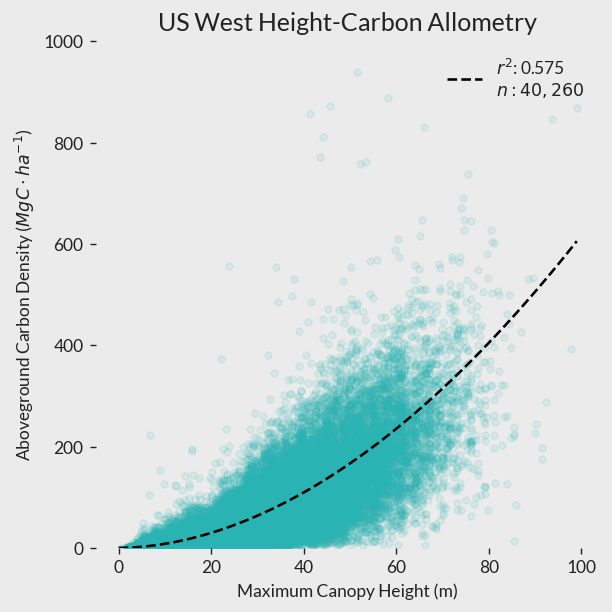

In [9]:
# plotting defaults
plt.figure(figsize=(5,5), dpi=125)

# data prep
ycarbon = cm.predict_proba(x)
xrange = np.arange(0, x.max(), 1).reshape(-1,1)
yrange = cm.predict_proba(xrange)

# base plot
plt.scatter(x, y*0.48, alpha=0.1)
plt.plot(xrange, yrange, color='black', linestyle='--', label=f"$r^2$: {r2:0.3f}\n$n: {len(y):,}$", linewidth=1.5)

ymax = 1000
plt.ylim(0, ymax)

plt.xlabel("Maximum Canopy Height (m)")
plt.ylabel("Aboveground Carbon Density ($MgC\cdot ha^{-1}$)")
plt.title(f"US West Height-Carbon Allometry")
plt.legend()
plt.tight_layout()
plt.savefig("uswest-allometry.png")

In [8]:
ela.apply_model_to_rasters(
    cm,
    'SierraEcoregion-Vegetation-CanopyHeight-2020-Spring-00030m.tif',
    'SierraEcoregion-Vegetation-AbovegroundCarbonDensity-2020-Spring-00030m.tif',
    predict_proba=True,
)

Window:   0%|                              | 0/16728 [00:00<?, ?it/s]